In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import compute_sample_weight

# Get data and pre-process

In [2]:
def delay_to_status(delay):
    if delay < -10:
        return "Early"
    elif -10 <= delay <= 10:
        return "On-time"
    elif 10 < delay <= 30:
        return "Late"
    else:
        return "Severely Late"

In [3]:
# Load the historical data into a pandas dataframe
flight_data = pd.read_csv("data/flight_data.csv", parse_dates=['Date (MM/DD/YYYY)'])
origin_weather_data = pd.read_csv("data/origin_weather.csv", parse_dates=['origin_time'])
destination_weather_data = pd.read_csv("data/weather/SYR.csv", parse_dates=['time'])

# Categorize delays
flight_data['Status'] = flight_data['Arrival Delay (Minutes)'].apply(delay_to_status)

# Drop unnecessary columns
flight_data.drop(columns=[
    'Flight Number',
    'Tail Number',
    'Scheduled Arrival Time',
    'Scheduled Elapsed Time (Minutes)',
    'Arrival Delay (Minutes)',
    'Wheels-on Time',
    'Taxi-In time (Minutes)',
    'Delay Carrier (Minutes)',
    'Delay Weather (Minutes)',
    'Delay National Aviation System (Minutes)',
    'Delay Security (Minutes)',
    'Delay Late Aircraft Arrival (Minutes)'
], inplace=True)

# Handle missing values
flight_data.dropna(inplace=True)

# Add Arrival Datetime

In [4]:
# Create a boolean mask to identify rows with '24:00:00'
mask_24 = flight_data['Actual Arrival Time'] == '24:00:00'

# Replace '24:00:00' with '00:00:00'
flight_data['Actual Arrival Time'] = flight_data['Actual Arrival Time'].replace('24:00:00', '00:00:00')

# Combine date and time columns
flight_data['Arrival Datetime'] = pd.to_datetime(
    flight_data['Date (MM/DD/YYYY)'].astype(str) + ' ' + flight_data['Actual Arrival Time'])

# Add a day to the date part when the original time value was '24:00:00'
flight_data.loc[mask_24, 'Arrival Datetime'] = flight_data.loc[mask_24, 'Arrival Datetime'] + pd.Timedelta(days=1)

# Show 10 rows of the dataframe
flight_data.head(10)

,Date (MM/DD/YYYY),Origin Airport,Actual Arrival Time,Actual Elapsed Time (Minutes),Status,Arrival Datetime
0,1988-01-01,ORD,19:13,79,Early,1988-01-01 19:13:00
1,1988-01-01,ORD,22:41,95,On-time,1988-01-01 22:41:00
2,1989-01-01,ORD,18:27,89,Severely Late,1989-01-01 18:27:00
3,1989-01-01,ORD,20:55,113,Severely Late,1989-01-01 20:55:00
4,1989-01-01,ORD,9:00,96,On-time,1989-01-01 09:00:00
5,1989-01-01,ORD,23:37,110,Severely Late,1989-01-01 23:37:00
6,1989-01-01,IAD,15:28,120,Severely Late,1989-01-01 15:28:00
7,1989-01-01,IAD,23:39,91,Severely Late,1989-01-01 23:39:00
8,1990-01-01,ORD,16:48,120,Late,1990-01-01 16:48:00
9,1990-01-01,ORD,22:51,100,On-time,1990-01-01 22:51:00


# Add Departure Datetime

In [5]:
# Convert the 'Actual Elapsed Time (Minutes)' to a timedelta
flight_data['Actual Elapsed Time'] = pd.to_timedelta(flight_data['Actual Elapsed Time (Minutes)'], unit='m')

# Subtract the 'Actual Elapsed Time' from the 'Arrival Datetime' to create the 'Departure Datetime' column
flight_data['Departure Datetime'] = flight_data['Arrival Datetime'] - flight_data['Actual Elapsed Time']

# Show 10 rows of the dataframe
flight_data.head(10)

,Date (MM/DD/YYYY),Origin Airport,Actual Arrival Time,Actual Elapsed Time (Minutes),Status,Arrival Datetime,Actual Elapsed Time,Departure Datetime
0,1988-01-01,ORD,19:13,79,Early,1988-01-01 19:13:00,0 days 01:19:00,1988-01-01 17:54:00
1,1988-01-01,ORD,22:41,95,On-time,1988-01-01 22:41:00,0 days 01:35:00,1988-01-01 21:06:00
2,1989-01-01,ORD,18:27,89,Severely Late,1989-01-01 18:27:00,0 days 01:29:00,1989-01-01 16:58:00
3,1989-01-01,ORD,20:55,113,Severely Late,1989-01-01 20:55:00,0 days 01:53:00,1989-01-01 19:02:00
4,1989-01-01,ORD,9:00,96,On-time,1989-01-01 09:00:00,0 days 01:36:00,1989-01-01 07:24:00
5,1989-01-01,ORD,23:37,110,Severely Late,1989-01-01 23:37:00,0 days 01:50:00,1989-01-01 21:47:00
6,1989-01-01,IAD,15:28,120,Severely Late,1989-01-01 15:28:00,0 days 02:00:00,1989-01-01 13:28:00
7,1989-01-01,IAD,23:39,91,Severely Late,1989-01-01 23:39:00,0 days 01:31:00,1989-01-01 22:08:00
8,1990-01-01,ORD,16:48,120,Late,1990-01-01 16:48:00,0 days 02:00:00,1990-01-01 14:48:00
9,1990-01-01,ORD,22:51,100,On-time,1990-01-01 22:51:00,0 days 01:40:00,1990-01-01 21:11:00


# Cleanup Datetime columns

In [6]:
# Drop more unnecessary date columns
flight_data.drop(columns=[
    'Date (MM/DD/YYYY)',
    'Actual Arrival Time',
    'Actual Elapsed Time'
], inplace=True)

# Round to the nearest hour for the weather data
flight_data['Arrival Datetime'] = flight_data['Arrival Datetime'].dt.round("H")
flight_data['Departure Datetime'] = flight_data['Departure Datetime'].dt.round("H")

# Show 10 rows of the dataframe
flight_data.head(10)

,Origin Airport,Actual Elapsed Time (Minutes),Status,Arrival Datetime,Departure Datetime
0,ORD,79,Early,1988-01-01 19:00:00,1988-01-01 18:00:00
1,ORD,95,On-time,1988-01-01 23:00:00,1988-01-01 21:00:00
2,ORD,89,Severely Late,1989-01-01 18:00:00,1989-01-01 17:00:00
3,ORD,113,Severely Late,1989-01-01 21:00:00,1989-01-01 19:00:00
4,ORD,96,On-time,1989-01-01 09:00:00,1989-01-01 07:00:00
5,ORD,110,Severely Late,1989-01-02 00:00:00,1989-01-01 22:00:00
6,IAD,120,Severely Late,1989-01-01 15:00:00,1989-01-01 13:00:00
7,IAD,91,Severely Late,1989-01-02 00:00:00,1989-01-01 22:00:00
8,ORD,120,Late,1990-01-01 17:00:00,1990-01-01 15:00:00
9,ORD,100,On-time,1990-01-01 23:00:00,1990-01-01 21:00:00


# Get Date Ranges for Weather Data

In [7]:
# Group flight_data by 'Origin Airport' and aggregate the min and max 'Departure Datetime' for each group
date_ranges = flight_data.groupby('Origin Airport')['Departure Datetime'].agg(['min', 'max'])

# Print the 'Origin Airport' and the date range for each group
for index, row in date_ranges.iterrows():
    print(f"Origin Airport: {index}")
    print(f"Date Range: {row['min'].strftime('%Y-%m-%d %H:%M')} - {row['max'].strftime('%Y-%m-%d %H:%M')}\n")

min_departure = flight_data['Departure Datetime'].min()
max_departure = flight_data['Departure Datetime'].max()

print(
    f"Overall Date Range: {min_departure.strftime('%Y-%m-%d %H:%M')} - {max_departure.strftime('%Y-%m-%d %H:%M')}")

Origin Airport: DEN
Date Range: 2022-02-11 12:00 - 2023-01-31 12:00

Origin Airport: EWR
Date Range: 2019-11-30 22:00 - 2023-01-31 22:00

Origin Airport: IAD
Date Range: 1988-06-09 20:00 - 2023-01-02 22:00

Origin Airport: ORD
Date Range: 1987-10-01 08:00 - 2023-01-31 19:00

Overall Date Range: 1987-10-01 08:00 - 2023-01-31 22:00


# Join Flight Data with Origin Weather Data

In [8]:
# Merge the flight_data and origin_weather_data dataframes on 'Departure Datetime' and 'Origin Airport' columns using a left join
merged_data = pd.merge(flight_data, origin_weather_data,
                       left_on=['Departure Datetime', 'Origin Airport'],
                       right_on=['origin_time', 'origin_airport'],
                       how='left')

# Drop more unnecessary date columns
merged_data.drop(columns=[
    'Departure Datetime',
    'origin_time',
    'origin_airport'
], inplace=True)

# Show 10 rows of the dataframe
merged_data.head(10)

,Origin Airport,Actual Elapsed Time (Minutes),Status,Arrival Datetime,origin_temperature_2m (°C),origin_relativehumidity_2m (%),origin_dewpoint_2m (°C),origin_apparent_temperature (°C),origin_pressure_msl (hPa),origin_surface_pressure (hPa),...,origin_cloudcover_low (%),origin_cloudcover_mid (%),origin_cloudcover_high (%),origin_windspeed_10m (km/h),origin_windspeed_100m (km/h),origin_winddirection_10m (°),origin_winddirection_100m (°),origin_windgusts_10m (km/h),origin_et0_fao_evapotranspiration (mm),origin_vapor_pressure_deficit (kPa)
0,ORD,79,Early,1988-01-01 19:00:00,-15.3,71,-19.3,-21.9,1034.9,1007.5,...,0,0,0,19.6,32.0,253,255,39.2,0.02,0.05
1,ORD,95,On-time,1988-01-01 23:00:00,-16.3,72,-20.1,-22.8,1035.4,1007.9,...,0,0,0,18.5,33.5,263,266,33.5,0.01,0.05
2,ORD,89,Severely Late,1989-01-01 18:00:00,0.5,73,-3.8,-4.4,1016.2,990.8,...,0,0,5,15.6,23.1,214,214,30.2,0.07,0.17
3,ORD,113,Severely Late,1989-01-01 21:00:00,-1.7,82,-4.3,-6.9,1016.2,990.6,...,6,0,5,17.1,32.1,221,224,28.8,0.02,0.10
4,ORD,96,On-time,1989-01-01 09:00:00,-6.0,94,-6.9,-10.0,1018.9,992.9,...,13,0,0,6.9,11.6,186,175,10.8,0.00,0.02
5,ORD,110,Severely Late,1989-01-02 00:00:00,-2.7,85,-4.8,-8.1,1016.0,990.3,...,79,0,61,18.2,32.5,240,244,32.8,0.01,0.07
6,IAD,120,Severely Late,1989-01-01 15:00:00,1.2,99,1.1,-2.1,1020.8,1009.2,...,100,88,0,9.1,14.8,83,86,23.0,0.03,0.01
7,IAD,91,Severely Late,1989-01-02 00:00:00,1.2,99,1.0,-1.2,1020.6,1009.0,...,100,16,0,2.4,4.8,333,13,9.0,0.00,0.01
8,ORD,120,Late,1990-01-01 17:00:00,-2.0,68,-7.1,-7.3,1024.2,998.4,...,100,0,0,15.6,21.4,263,263,33.1,0.07,0.17
9,ORD,100,On-time,1990-01-01 23:00:00,-3.0,71,-7.4,-8.4,1024.3,998.4,...,35,0,0,16.7,28.4,217,219,29.5,0.02,0.14


# Join Flight Data with Destination Weather Data

In [9]:
# First, add the 'destination_' prefix to all column names in the destination_weather_data dataframe
destination_weather_data = destination_weather_data.add_prefix('destination_')

# Merge the merged_data and destination_weather_data dataframes on 'Arrival Datetime', 'time' and 'Origin Airport' columns using a left join
data = pd.merge(merged_data, destination_weather_data, left_on='Arrival Datetime', right_on='destination_time',
                how='left')

# Drop more unnecessary date columns
data.drop(columns=[
    'Arrival Datetime',
    'destination_time',
], inplace=True)

# Show 10 rows of the dataframe
data.head(10)

,Origin Airport,Actual Elapsed Time (Minutes),Status,origin_temperature_2m (°C),origin_relativehumidity_2m (%),origin_dewpoint_2m (°C),origin_apparent_temperature (°C),origin_pressure_msl (hPa),origin_surface_pressure (hPa),origin_precipitation (mm),...,destination_cloudcover_low (%),destination_cloudcover_mid (%),destination_cloudcover_high (%),destination_windspeed_10m (km/h),destination_windspeed_100m (km/h),destination_winddirection_10m (°),destination_winddirection_100m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa)
0,ORD,79,Early,-15.3,71,-19.3,-21.9,1034.9,1007.5,0.0,...,79,9,0,15.4,25.9,254,256,31.7,0.02,0.16
1,ORD,95,On-time,-16.3,72,-20.1,-22.8,1035.4,1007.9,0.0,...,89,16,0,17.2,29.1,259,262,38.9,0.02,0.16
2,ORD,89,Severely Late,0.5,73,-3.8,-4.4,1016.2,990.8,0.0,...,42,24,0,9.7,20.1,141,153,21.2,0.01,0.12
3,ORD,113,Severely Late,-1.7,82,-4.3,-6.9,1016.2,990.6,0.0,...,85,21,63,14.9,27.4,173,178,31.3,0.01,0.14
4,ORD,96,On-time,-6.0,94,-6.9,-10.0,1018.9,992.9,0.0,...,8,45,11,10.0,21.9,120,131,18.4,0.00,0.03
5,ORD,110,Severely Late,-2.7,85,-4.8,-8.1,1016.0,990.3,0.0,...,71,4,94,15.8,28.9,180,184,34.2,0.01,0.12
6,IAD,120,Severely Late,1.2,99,1.1,-2.1,1020.8,1009.2,1.2,...,17,2,0,10.6,16.5,145,148,24.1,0.11,0.25
7,IAD,91,Severely Late,1.2,99,1.0,-1.2,1020.6,1009.0,0.0,...,71,4,94,15.8,28.9,180,184,34.2,0.01,0.12
8,ORD,120,Late,-2.0,68,-7.1,-7.3,1024.2,998.4,0.0,...,83,20,0,21.6,36.1,294,295,51.5,0.03,0.12
9,ORD,100,On-time,-3.0,71,-7.4,-8.4,1024.3,998.4,0.0,...,88,0,0,16.3,28.2,298,300,37.8,0.01,0.08


# Check Data

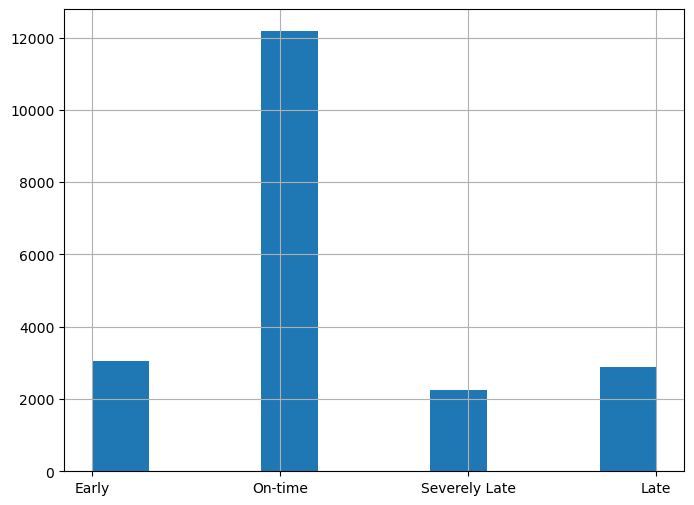

Length of flight data:  20352
Length of merged data:  20352
Total NaN values:  0


In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
data['Status'].hist(ax=ax)
plt.show()

print("Length of flight data: ", len(flight_data))
print("Length of merged data: ", len(data))
print("Total NaN values: ", data.isna().sum().sum())

# One Hot Encoding

In [11]:
# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Origin Airport'])

# Split data into testing and training

In [12]:
X = data.drop(columns=['Status'])
y = data['Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the length of the train and test data
print("Length of train dataset: ", len(X_train))
print("Length of test dataset: ", len(X_test))

Length of train dataset:  16281
Length of test dataset:  4071


# Normalize data

In [13]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Show 10 rows of the dataframe
X_train.head(10)

,Actual Elapsed Time (Minutes),origin_temperature_2m (°C),origin_relativehumidity_2m (%),origin_dewpoint_2m (°C),origin_apparent_temperature (°C),origin_pressure_msl (hPa),origin_surface_pressure (hPa),origin_precipitation (mm),origin_rain (mm),origin_snowfall (cm),...,destination_windspeed_100m (km/h),destination_winddirection_10m (°),destination_winddirection_100m (°),destination_windgusts_10m (km/h),destination_et0_fao_evapotranspiration (mm),destination_vapor_pressure_deficit (kPa),Origin Airport_DEN,Origin Airport_EWR,Origin Airport_IAD,Origin Airport_ORD
14100,0.181159,0.796089,0.844444,0.918239,0.803898,0.396135,0.851054,0.0,0.0,0.0,...,0.262222,0.983287,0.011142,0.267778,0.0000,0.002558,0.0,0.0,1.0,0.0
9830,0.236715,0.737430,0.955556,0.880503,0.739342,0.391304,0.789227,0.0,0.0,0.0,...,0.468148,0.420613,0.426184,0.424444,0.3750,0.294118,0.0,0.0,0.0,1.0
16218,0.205314,0.593575,0.633333,0.635220,0.561510,0.566828,0.834660,0.0,0.0,0.0,...,0.223704,0.963788,0.966574,0.255556,0.0250,0.097187,0.0,0.0,0.0,1.0
16870,0.234300,0.512570,0.377778,0.462264,0.451888,0.438003,0.795785,0.0,0.0,0.0,...,0.320000,0.754875,0.757660,0.272222,0.0250,0.076726,0.0,0.0,0.0,1.0
7831,0.210145,0.660615,0.800000,0.756289,0.632156,0.425121,0.796721,0.0,0.0,0.0,...,0.057778,0.562674,0.559889,0.112222,0.2750,0.125320,0.0,0.0,0.0,1.0
4073,0.239130,0.361732,0.411111,0.320755,0.304507,0.760064,0.882436,0.0,0.0,0.0,...,0.445926,0.863510,0.866295,0.300000,0.0375,0.015345,0.0,0.0,0.0,1.0
5084,0.256039,0.465084,0.866667,0.555031,0.436054,0.574879,0.833255,0.0,0.0,0.0,...,0.093333,0.167131,0.161560,0.112222,0.2250,0.069054,0.0,0.0,0.0,1.0
1965,0.227053,0.439944,0.888889,0.533019,0.406821,0.487923,0.807963,0.0,0.0,0.0,...,0.361481,0.437326,0.454039,0.264444,0.0250,0.023018,0.0,0.0,0.0,1.0
18400,0.236715,0.520950,0.688889,0.575472,0.489647,0.465378,0.803747,0.0,0.0,0.0,...,0.426667,0.818942,0.827298,0.355556,0.0125,0.038363,0.0,0.0,0.0,1.0
11829,0.212560,0.900838,0.244444,0.779874,0.857491,0.465378,0.814052,0.0,0.0,0.0,...,0.164444,0.654596,0.679666,0.192222,0.1000,0.069054,0.0,0.0,0.0,1.0


# Training

In [14]:
# Instantiate the LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable in the training set
y_train_encoded = le.fit_transform(y_train)

# Transform the target variable in the testing set
y_test_encoded = le.transform(y_test)

# Calculate the sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Create and train the XGBoost model
xgbr = xgb.XGBClassifier(objective='multi:softmax', n_estimators=100, seed=42)
xgbr.fit(X_train, y_train_encoded, sample_weight=sample_weights)

# Make predictions
y_train_pred_encoded = xgbr.predict(X_train)
y_test_pred_encoded = xgbr.predict(X_test)

# Inverse transform the predictions back to the original labels
y_train_pred = le.inverse_transform(y_train_pred_encoded)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

# Evaluate the model

In [15]:
print('Training Classification report:')
print(classification_report(y_train, y_train_pred))

print('\nTesting Classification report:')
print(classification_report(y_test, y_test_pred))

Training Classification report:
               precision    recall  f1-score   support

        Early       0.70      0.98      0.82      2437
         Late       0.86      0.94      0.90      2302
      On-time       0.98      0.84      0.91      9740
Severely Late       0.88      0.97      0.92      1802

     accuracy                           0.89     16281
    macro avg       0.85      0.93      0.89     16281
 weighted avg       0.91      0.89      0.89     16281


Testing Classification report:
               precision    recall  f1-score   support

        Early       0.43      0.65      0.52       610
         Late       0.42      0.40      0.41       575
      On-time       0.77      0.69      0.73      2436
Severely Late       0.42      0.38      0.40       450

     accuracy                           0.61      4071
    macro avg       0.51      0.53      0.51      4071
 weighted avg       0.63      0.61      0.62      4071



In [16]:
test_output = pd.DataFrame({'actual': y_test, 'predicted': y_test_pred})

test_output.head(30)

,actual,predicted
13435,On-time,On-time
7552,On-time,On-time
6981,On-time,On-time
7257,On-time,On-time
4813,On-time,Early
2013,On-time,Late
14330,On-time,On-time
7137,Late,Late
15933,On-time,On-time
10742,Late,Late


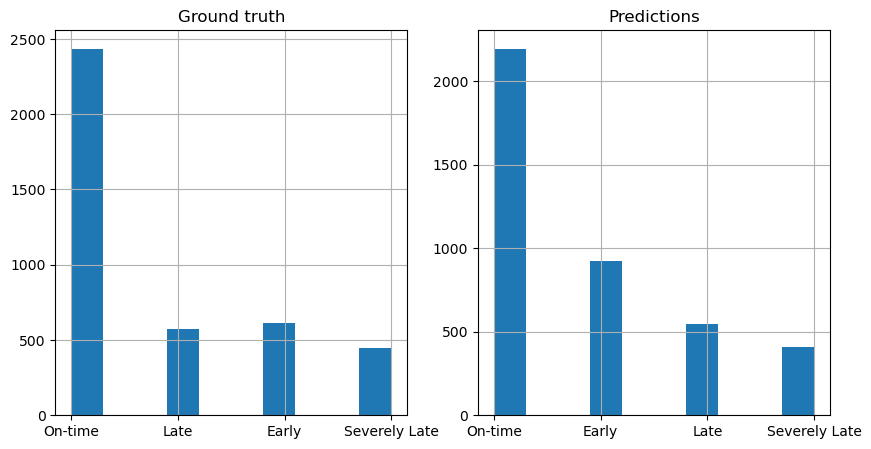

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
test_output.actual.hist(ax=ax[0])
test_output.predicted.hist(ax=ax[1])
ax[0].set_title('Ground truth')
ax[1].set_title('Predictions')
plt.show()